In [1]:
import os
import cv2
import numpy as np
import random
from PIL import Image

from matplotlib import pyplot as plt
from tensorflow import keras
import tensorflow as tf

In [2]:
## 이미지 불러와서 이미지 크기를 임의의 크기 으로 이미지 리사이즈

# all_folders 은 폴더 명만 나와야됨(ex) green, red, yellow
all_folders = os.listdir("data/")
# all_folders.remove(".DS_Store")

# 각 green, red, yellow 폴더에 들어가있는 신호등 이미지가 변환되서 저장됨(원본 사라짐)
for x in all_folders:
    path = 'data/'+x+'/' 
    file_list = os.listdir(path) # 폴더 하나마다 들어있는 파일들 리스트 저장

    for A in file_list:
        if A == ".DS_Store":
            continue
        img = cv2.imread(path + A)
        # res = cv2.resize(img, dsize = (30, 10), interpolation=cv2.INTER_CUBIC)
        res = cv2.resize(img, dsize = (45, 15), interpolation = cv2.INTER_CUBIC)
        cv2.imwrite(path + A, res)

In [3]:
c = os.listdir("data")
# c.remove(".DS_Store") #['.DS_Store','green','red','yellow']

print(c) # 0,1,2 지정할 때 순서 확인

['green', 'red', 'yellow']


In [4]:
class Data():
    def __init__(self):
        
        self.train_x = []
        self.train_y = []
        self.test_x = []
        self.test_y = []
        
        self.images()
        
    def images(self):
        data = []
        classes = os.listdir("data")
        if ".DS_Store" in classes:
            classes.remove(".DS_Store")
        for i, light in enumerate(classes): #green:0 red:1 yellow:2
            PATH = os.listdir("data/" + light)
            if ".DS_Store" in PATH:
                PATH.remove(".DS_Store")
            for x in PATH:
                img = Image.open("data/"+ light + "/" + x)
                data.append((np.asarray(img),i))
                img.close()
                
        random.shuffle(data)
        
        # 데이터 분할
        for i in range(len(data)):
            if i < 0.8 * len(data):
                self.train_x.append(data[i][0])
                self.train_y.append(data[i][1])
            else:
                self.test_x.append(data[i][0])
                self.test_y.append(data[i][1])
                
        self.train_x = (np.asarray(self.train_x) - np.min(self.train_x, axis = 0)) / (np.max(self.train_x, axis = 0) - np.min(self.train_x, axis = 0))
        self.train_y = np.asarray(self.train_y)
        
        self.test_x = (np.asarray(self.test_x) - np.min(self.test_x, axis = 0)) / (np.max(self.test_x, axis = 0) - np.min(self.test_x, axis = 0))
        self.test_y = np.asarray(self.test_y)
                
#         self.train_x = np.asarray(self.train_x) / 255.0
#         self.test_x = np.asarray(self.test_x) / 255.0
        
#         self.train_y = np.asarray(self.train_y)
#         self.test_y = np.asarray(self.test_y)
        
        print("train x size : " + str(self.train_x.shape))
        print("train y size : " + str(self.train_y.shape))
        print("test x size : " + str(self.test_x.shape))
        print("test y size : " + str(self.test_y.shape))
        
    def draw_graph(history):
        train_history = history.history["loss"]
        validation_history = history.history["val_loss"]
        fig = plt.figure(figsize = (8, 8))
        plt.title("Loss History")
        plt.xlabel("EPOCH")
        plt.ylabel("LOSS Function")
        plt.plot(train_history, "red")
        plt.plot(validation_history, 'blue')
        fig.savefig("train_history.png")

        train_history = history.history["accuracy"]
        validation_history = history.history["val_accuracy"]
        fig = plt.figure(figsize = (8, 8))
        plt.title("Accuracy History")
        plt.xlabel("EPOCH")
        plt.ylabel("Accuracy")
        plt.plot(train_history, "red")
        plt.plot(validation_history, 'blue')
        fig.savefig("accuracy_history.png")

In [21]:
A = Data()

train x size : (19844, 15, 45, 3)
train y size : (19844,)
test x size : (4961, 15, 45, 3)
test y size : (4961,)


In [22]:
model = keras.Sequential([
    keras.layers.Conv2D(16, (5, 5), activation = "relu"),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.5),
    
    keras.layers.Conv2D(32, (3, 3), activation = "relu"),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.2),
    
#     keras.layers.Conv2D(64, (3, 3), activation = "relu"),
#     keras.layers.MaxPooling2D((2, 2)),
#     keras.layers.Dropout(0.3),
    
#     keras.layers.Conv2D(128, (3, 3), activation = "relu"),
#     keras.layers.MaxPooling2D((2, 2)),
#     keras.layers.Dropout(0.3),
    
    keras.layers.Dense(256, activation = 'relu'),
    
    keras.layers.Flatten(),
    
    keras.layers.Dense(128, activation = "relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64, activation = "relu"),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(32, activation = "relu"),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(3, activation = "softmax")
])

In [23]:
model.compile(optimizer = keras.optimizers.Adam(learning_rate = 0.0001),
              metrics = ["accuracy"], 
              loss = "sparse_categorical_crossentropy")

In [24]:
Epochs = 15

In [25]:
early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5)

In [26]:
history = model.fit(A.train_x, A.train_y, 
                    epochs = Epochs,
                    batch_size = 128,
                    validation_data = (A.test_x, A.test_y),
                    callbacks = [early_stop]
                    )

Epoch 1/15
156/156 [==============================] - 5s 26ms/step - loss: 0.5641 - accuracy: 0.7803 - val_loss: 0.0652 - val_accuracy: 0.9946
Epoch 2/15
156/156 [==============================] - 4s 25ms/step - loss: 0.0760 - accuracy: 0.9770 - val_loss: 0.0154 - val_accuracy: 0.9974
Epoch 3/15
156/156 [==============================] - 4s 23ms/step - loss: 0.0378 - accuracy: 0.9889 - val_loss: 0.0106 - val_accuracy: 0.9978
Epoch 4/15
156/156 [==============================] - 4s 26ms/step - loss: 0.0296 - accuracy: 0.9917 - val_loss: 0.0088 - val_accuracy: 0.9984
Epoch 5/15
156/156 [==============================] - 4s 24ms/step - loss: 0.0235 - accuracy: 0.9945 - val_loss: 0.0083 - val_accuracy: 0.9980
Epoch 6/15
156/156 [==============================] - 4s 24ms/step - loss: 0.0194 - accuracy: 0.9954 - val_loss: 0.0079 - val_accuracy: 0.9980
Epoch 7/15
156/156 [==============================] - 4s 23ms/step - loss: 0.0165 - accuracy: 0.9963 - val_loss: 0.0075 - val_accuracy: 0.9982

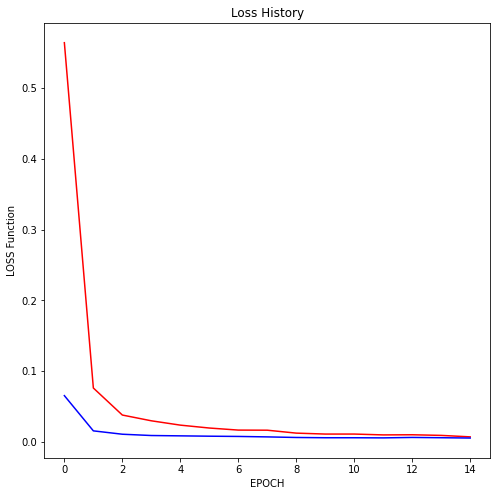

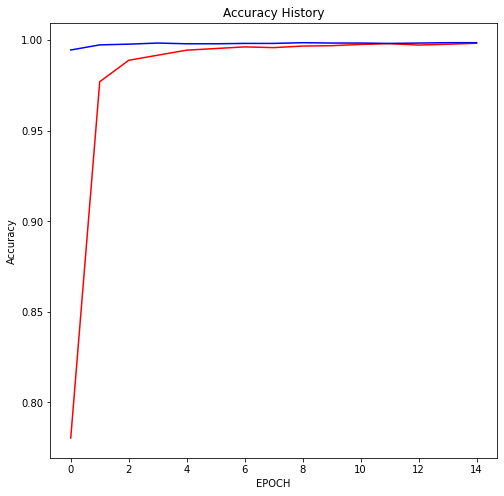

In [27]:
Data.draw_graph(history)

In [28]:
# 모델 저장
model.save("traffic_light_0315_3.h5")

In [29]:
# 모델 불러오기

In [36]:
model = tf.keras.models.load_model('traffic_light_0315_2.h5')

In [37]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 11, 41, 16)        1216      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 5, 20, 16)        0         
 2D)                                                             
                                                                 
 dropout_15 (Dropout)        (None, 5, 20, 16)         0         
                                                                 
 conv2d_7 (Conv2D)           (None, 3, 18, 32)         4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 1, 9, 32)         0         
 2D)                                                             
                                                                 
 dropout_16 (Dropout)        (None, 1, 9, 32)         

In [38]:
Path2 = 'data_2/all/'
file_list = os.listdir(Path2)

if ".DS_Store" in file_list:
    file_list.remove(".DS_Store")

data2 = []

for A in file_list:
    if A == ".DS_Store":
        continue
    img2 = cv2.imread(Path2 + A)
    res2 = cv2.resize(img2, dsize = (45, 15), interpolation = cv2.INTER_CUBIC)
    cv2.imwrite(Path2 + A, res2)
    
for A in file_list:
    if A == ".DS_Store":
        continue
    img3 = Image.open(Path2 + A)
    data2.append(np.array(img3))
    img3.close()

In [39]:
data2 = np.asarray(data2) / 255.0

In [40]:
prediction = model.predict(data2)

In [41]:
light_order = {0:"green",1:"red",2:"yellow"}

for i,x in enumerate(prediction):
    count = 0
    for y in x:
        if y > 0.95:
            count += 1
    if count > 0:
        print(str(i)+"번째 신호등: " + file_list[i] + " : " + light_order[np.argmax(x)])

2번째 신호등: 13668147_143.jpg : yellow
5번째 신호등: 227331.jpg : yellow
15번째 신호등: 2348.jpg : yellow
16번째 신호등: 2349.jpg : yellow
17번째 신호등: 24349.jpg : red
25번째 신호등: 24357.jpg : green
26번째 신호등: 24358.jpg : green
29번째 신호등: 79465.jpg : red
44번째 신호등: 81338.jpg : green
46번째 신호등: 81340.jpg : green
47번째 신호등: 81341.jpg : green


# 이미지랑 같이 출력

0.94616586
0.050545573
0.0032885973
Unknown


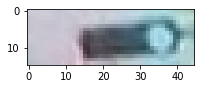

0.1389931
0.16272065
0.6982863
Unknown


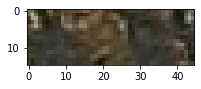

0.0039891424
0.025361966
0.9706489
2번째 신호등: 13668147_143.jpg : yellow


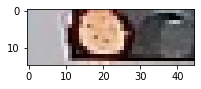

0.1366422
0.7884392
0.07491861
Unknown


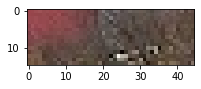

0.58206475
0.3725774
0.04535783
Unknown


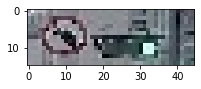

0.006866842
0.00084901386
0.9922841
5번째 신호등: 227331.jpg : yellow


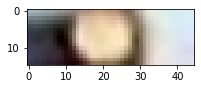

0.18081583
0.047110096
0.7720741
Unknown


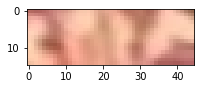

0.3060183
0.29406944
0.39991233
Unknown


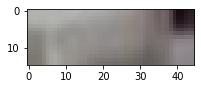

0.061011653
0.89945376
0.039534602
Unknown


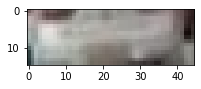

0.19349279
0.12603459
0.6804726
Unknown


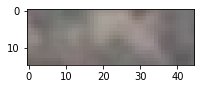

0.12407399
0.07566712
0.8002589
Unknown


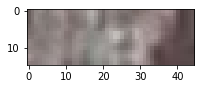

0.19099386
0.119878806
0.6891273
Unknown


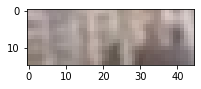

0.23382576
0.11676108
0.64941317
Unknown


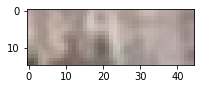

0.51972276
0.32508662
0.15519054
Unknown


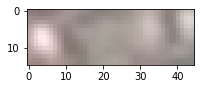

0.21218805
0.5911709
0.19664101
Unknown


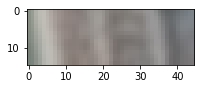

0.0011768955
0.0005999468
0.9982231
15번째 신호등: 2348.jpg : yellow


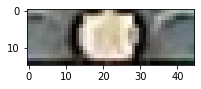

0.000695204
0.0003010717
0.9990037
16번째 신호등: 2349.jpg : yellow


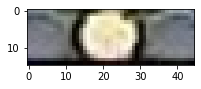

5.7076373e-05
0.9999311
1.1743538e-05
17번째 신호등: 24349.jpg : red


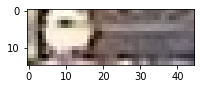

0.65589017
0.17344204
0.17066774
Unknown


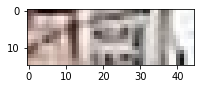

0.13761665
0.046294056
0.8160893
Unknown


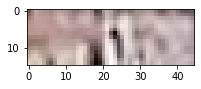

0.34122255
0.28517482
0.37360263
Unknown


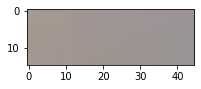

0.37875527
0.22427814
0.3969666
Unknown


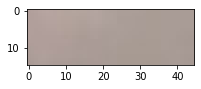

0.20512545
0.44376713
0.3511075
Unknown


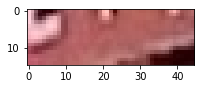

0.6647052
0.13494627
0.20034848
Unknown


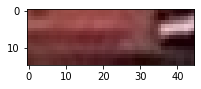

0.13997246
0.068960376
0.7910672
Unknown


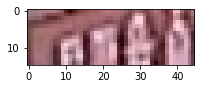

0.9900794
0.004684026
0.0052365605
25번째 신호등: 24357.jpg : green


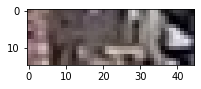

0.9606156
0.01699112
0.022393323
26번째 신호등: 24358.jpg : green


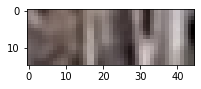

0.06475522
0.04050255
0.8947422
Unknown


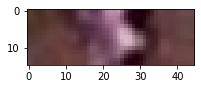

0.21805464
0.06892803
0.7130173
Unknown


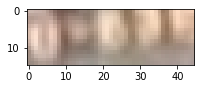

3.2378096e-06
0.9999962
5.367381e-07
29번째 신호등: 79465.jpg : red


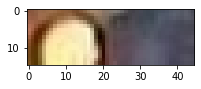

0.62649757
0.15778542
0.21571706
Unknown


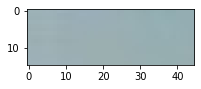

0.4404228
0.15853135
0.40104583
Unknown


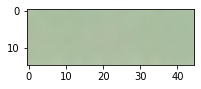

0.2953019
0.01239523
0.6923028
Unknown


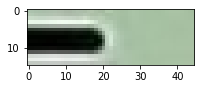

0.23032157
0.5479672
0.22171126
Unknown


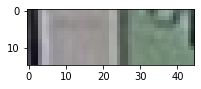

0.4042441
0.22574669
0.3700092
Unknown


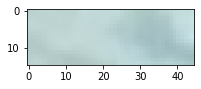

0.85475725
0.051312122
0.09393069
Unknown


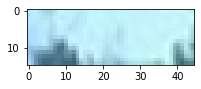

0.8356363
0.062117152
0.1022466
Unknown


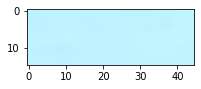

0.8521206
0.057134192
0.090745315
Unknown


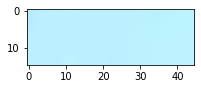

0.8158707
0.06796189
0.11616733
Unknown


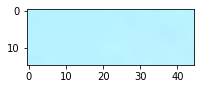

0.8353577
0.06126593
0.10337643
Unknown


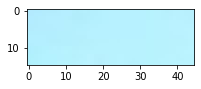

0.8284552
0.06441287
0.107131876
Unknown


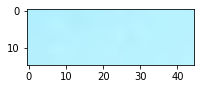

0.33426306
0.24514979
0.42058715
Unknown


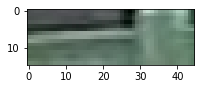

0.9412442
0.028503962
0.030251859
Unknown


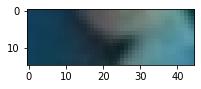

0.9166484
0.03516979
0.048181765
Unknown


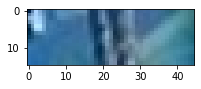

0.9998698
6.188884e-05
6.834991e-05
44번째 신호등: 81338.jpg : green


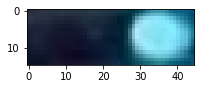

0.7891048
0.06970098
0.1411942
Unknown


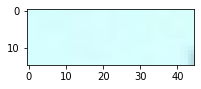

0.9998103
9.551945e-05
9.4272735e-05
46번째 신호등: 81340.jpg : green


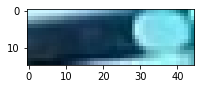

0.99995136
2.528063e-05
2.3410816e-05
47번째 신호등: 81341.jpg : green


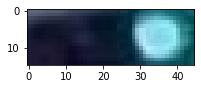

In [42]:
light_order = {0 : "green", 1 : "red", 2 : "yellow"}

for i, x in enumerate(prediction):
    count = 0
    
    for y in x:
        print(y)
        if y > 0.95:
            count += 1
        
    if count > 0:
        print(str(i)+"번째 신호등: " + file_list[i] + " : " + light_order[np.argmax(x)])
    else:
        print("Unknown")
      
    tstImg = cv2.imread(Path2 + file_list[i])
    tstImg = cv2.cvtColor(tstImg, cv2.COLOR_BGR2RGB)
    plt.figure(figsize = (3, 2))
    plt.imshow(tstImg)
    plt.show()
    print("=================================================")